In [4]:
import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
%matplotlib inline 

In [50]:
%load_ext line_profiler

The goal of this testing is to use the current function we have, then implement a dask version, then fix the boundary conditions. In practice, this test set does _not_ have periodic boundary conditions, but we will pretend it does so we can test our implementation. Since there are four index directions where the WHIM hits the boundary, this will be perfect!

In [3]:
# Set universal WHIM parameters to divide cosmic phase diagram into 4:
rhoMax = 100.
tMin = 10.**5

# Load in test sets
temp = np.load('./data/t_test.npy')
rho = np.load('./data/rho_test.npy')

halo_loc = (32,32,32)
size = 40 #Mpc
l = 2048

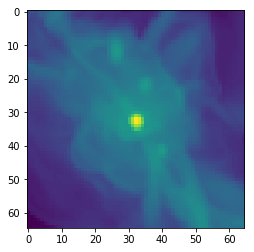

In [27]:
plt.imshow(np.log10(rho[32,:,:])) # Just to show the central point is here.

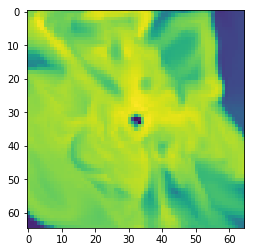

In [28]:
plt.imshow(np.log10(temp[32,:,:])) # Just to show the central point is here.

# Sanity checks with previous WHIM_size function

In [29]:
# The normal function we use:
def WHIM_size(rho, t, l, size, halo_i, halo_j, halo_k):
    '''
    This function will take in simulation data and a halo catalog and find the radial extent of the WHIM in 13 directions away (both ways, total 26) 
    from the center of the halo. 
    It does this by taking skewers through the halo and finding the size of the WHIM.
    Inputs:
        rho:        Baryon overdensity at each point in an array (mean is 1).
        t:bbb       Temperature at each point in an array.
        l:          The size of the full box in lattice points (assuming a cube).
        size:       Physical size of the full box in Mpc/h.
        halo_i,j,k: Halo location in the sub array.
    Returns:
        WHIMsize
    '''
    # Make array of halo_loc:
    halo_loc = np.array([halo_i,halo_j,halo_k],dtype=int)
    # Set up physical unit conversions:
    # Multiply by this to go from lattice points to Mpc/h
    convert_pt_Mpc = size/l

    # Get length of sub array to check we are still in halo
    sub_l = len(rho)

    # Now make a numpy array of all possible directions:
    indices = np.array([[0,0,1],[0,1,0],[1,0,0],[1,1,0],[1,0,1],[1,-1,0],
                        [1,0,-1],[0,1,-1],[0,1,1],[1,-1,-1],[1,-1,1],[-1,1,1],[1,1,1]])
    n_ind = len(indices) # Should be 13

    # Initialize an array to store sizes in each direction:
    # Note that it is 2 times since we will store the WHIM forward and backward along each direction
    WHIMsize = np.zeros(2*n_ind)

    # Also initialize counters so we know why we are dropping information:
    n_halo_bdry = 0
    n_WHIM_bdry = 0
    n_noWHIM = 0

    # Now step through each possible case:
    for i in range(n_ind):
        # First set fwd_i and bck_i to be the starting indices.
        # Note that we can't add one here in case the halo is at the edge
        # These have to be arrays so we can add to them.
        fwd_i = np.copy(halo_loc)
        bck_i = np.copy(halo_loc)
        # Check to see if we are still in halo. If so, advance the indices. Let's only check density and do temperature checks once out of the halo.
        # Because indices has positive and negative components, we need to check both and make sure we are in the box.
        # If we go past the edge of the halo, do not enter the WHIM loops. Set boolean variables for this:
        WHIM_fwd = True
        WHIM_bck = True
        while (rho[tuple(fwd_i)] > rhoMax):
            fwd_i += indices[i]
            if (np.any(fwd_i >= sub_l) | np.any(fwd_i <= 0)):
                #print("The halo extends past the sub box range!")
                n_halo_bdry += 1
                WHIM_fwd = False
                fwd_i = halo_loc # Set this so that we get NaN for WHIMsize.
                break
        while (rho[tuple(bck_i)] > rhoMax):
            bck_i -= indices[i]
            if (np.any(bck_i >= sub_l) | np.any(bck_i <= 0)):
                #print("The halo extends past the sub box range!")
                n_halo_bdry += 1
                WHIM_bck = False
                bck_i = halo_loc # Set this so that we get NaN for WHIMsize.
                break
        ### FORWARD
        # Now we need to check temperature, if we didn't already hit a boundary
        if WHIM_fwd:
            if (t[tuple(fwd_i)] < tMin):
                # It's possible we are still in the halo, but much more likely there just is no WHIM.
                fwd_i = halo_loc # Set this so that we get NaN for WHIMsize.
                n_noWHIM += 1
            else:
                # We should now be in the WHIM
                while ((rho[tuple(fwd_i)] < rhoMax) & (t[tuple(fwd_i)] > tMin) ):
                    fwd_i += indices[i]
                    if (np.any(fwd_i >= sub_l) | np.any(fwd_i <= 0)):
                        #print("The WHIM extends past the sub box range!")
                        n_WHIM_bdry += 1
                        fwd_i = halo_loc # Set this so that we get NaN for WHIMsize.
                        break
        ### BACKWARD
        # Now we need to check temperature, if we didn't already hit a boundary
        if WHIM_bck:
            if (t[tuple(bck_i)] < tMin):
                # It's possible we are still in the halo, but much more likely there just is no WHIM.
                bck_i = halo_loc # Set this so that we get NaN for WHIMsize.
                n_noWHIM += 1
            else:
                # We should now be in the WHIM
                while ((rho[tuple(bck_i)] < rhoMax) & (t[tuple(bck_i)] > tMin) ):
                    bck_i -= indices[i]
                    if (np.any(bck_i >= sub_l) | np.any(bck_i <= 0)):
                        #print("The WHIM extends past the sub box range!")
                        n_WHIM_bdry += 1
                        bck_i = halo_loc # Set this so that we get NaN for WHIMsize.
                        break

        # Set the WHIM size since we have now found it:
        WHIMsize[i] = np.linalg.norm(fwd_i - halo_loc)
        WHIMsize[n_ind+i] = np.linalg.norm(bck_i - halo_loc)

        # Put a warning up if we don't find any WHIM and set to NaN.
        if (WHIMsize[i] == 0.):
            #print("There is no WHIM in the forward ", i,"th direction, or the starting index wasn't correct")
            WHIMsize[i] = np.nan
        if (WHIMsize[n_ind+i] == 0.):
            #print("There is no WHIM in the backward ", i,"th direction, or the starting index wasn't correct")
            WHIMsize[n_ind+i] = np.nan
    
    # Convert to physical units:
    WHIMsize *= convert_pt_Mpc

    return WHIMsize, n_halo_bdry, n_WHIM_bdry, n_noWHIM

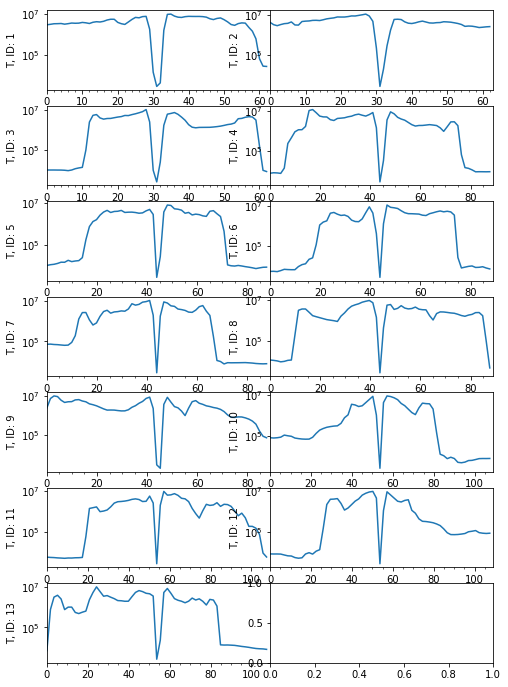

In [30]:
# Plot some skewers for a sanity check.
# Now make a numpy array of all possible directions:
indices = np.array([[0,0,1],[0,1,0],[1,0,0],[1,1,0],[1,0,1],[1,-1,0],[1,0,-1],[0,1,-1],[0,1,1],[1,-1,-1],[1,-1,1],[-1,1,1],[1,1,1]])
n_ind = len(indices) #Should be 13
# Now I want to plot all the skewers to make sure it all makes sense:
# 13 is a magic number here, but it is the number of possible indices.
fig2, [[ax1, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8], [ax9, ax10], [ax11, ax12], [ax13, ax14]] = plt.subplots(7,2,figsize=(8,12))
fig2.subplots_adjust(wspace=0)
# Do this for each index:
i=0
# Plot a subfigure for each skewer. This will plot symmetrically, so note that we will not see the entire data set.
# That's ok because we should want to double check that the skewers are roughly right.
for axis in fig2.axes:
    # Kill the loop before the 14th axis since we only have 13.
    if i == 13:
        axis.set_ylabel('')
        break
    # For each axis reset the skewer size and the indices
    skewer_count = 1
    fwd_i = np.asarray(halo_loc)
    bck_i = np.asarray(halo_loc)
    # Store t_data to plot for each skewer:
    t_data = [temp[tuple(fwd_i)]]
    # Step along indices until we hit the boundary, appending data.
    while ((np.max(fwd_i) < l-1) & (np.max(bck_i) < l-1) & (np.min(fwd_i) > 1) & (np.min(bck_i) > 1)):
        fwd_i += indices[i]#*skewer_count
        bck_i -= indices[i]#*skewer_count
        t_data.append(temp[tuple(fwd_i)])
        t_data.insert(0,temp[tuple(bck_i)])
        skewer_count += 2
    #print(skewer_count)
    axis.set_ylabel('T, ID: '+str(i+1))
    # Need to modify for step size, since along some axes the steps are larger
    step_size = np.linalg.norm(indices[i]-np.array([0,0,0]))
    axis.set_xlim(0,skewer_count*step_size)
    axis.semilogy(np.arange(0,skewer_count)*step_size,t_data,label=str(i+1))
    i+=1
    axis.minorticks_on() # Try having minor ticks to help

In [31]:
# So we should have 4 nans, which we do!
WHIM_size(rho, temp, 2048, 40, 32,32,32)

(array([ 0.56640625,         nan,  0.5859375 ,  0.63529125,  0.55242717,
         0.60766989,  0.4695631 ,  0.82864076,  0.82864076,  0.57509499,
         0.37212029,  0.64275323,  0.60892411,         nan,         nan,
         0.29296875,  0.74577668,  0.58004853,  0.52480581,  0.66291261,
         0.69053397,         nan,  0.64275323,  0.67658235,  0.57509499,
         1.04870264]), 0, 4, 0)

In [32]:
%%time
WHIM_size(rho, temp, 2048, 40, 32,32,32)

CPU times: user 25.4 ms, sys: 2.81 ms, total: 28.2 ms
Wall time: 26.1 ms


(array([ 0.56640625,         nan,  0.5859375 ,  0.63529125,  0.55242717,
         0.60766989,  0.4695631 ,  0.82864076,  0.82864076,  0.57509499,
         0.37212029,  0.64275323,  0.60892411,         nan,         nan,
         0.29296875,  0.74577668,  0.58004853,  0.52480581,  0.66291261,
         0.69053397,         nan,  0.64275323,  0.67658235,  0.57509499,
         1.04870264]), 0, 4, 0)

# Dask implementation of WHIM size

In [70]:
def da_WHIM_size(rho, temp, l, size, halo_i, halo_j, halo_k):
    '''
    This function will take in simulation data and a halo catalog as hdf5 files and read them in as dask arrays,
    before finding the radial extent of the WHIM in 13 directions away (both ways, total 26) from the center of 
    the halo. 
    It does this by taking skewers through the halo and finding the size of the WHIM.
    Inputs:
        rho:        Baryon overdensity at each point in an array (mean is 1).
        temp:       Temperature at each point in an array.
        l:          The size of the full box in lattice points (assuming a cube).
        size:       Physical size of the full box in Mpc/h.
        halo_i,j,k: Halo location in the sub array.
    Returns:
        WHIMsize
    '''
    # Use dask to read in arrays. Define chunk size as 1/4 in each direction:
#    chunk = int(l/4)
#    r = da.from_array(rho, chunks=(chunk,chunk,chunk))
#    t = da.from_array(temp, chunks=(chunk,chunk,chunk))
    
    # Make array of halo_loc:
    halo_loc = np.array([halo_i,halo_j,halo_k],dtype=int)
    # Set up physical unit conversions:
    # Multiply by this to go from lattice points to Mpc/h
    convert_pt_Mpc = size/l

    # Now make a numpy array of all possible directions:
    indices = np.array([[0,0,1],[0,1,0],[1,0,0],[1,1,0],[1,0,1],[1,-1,0],
                        [1,0,-1],[0,1,-1],[0,1,1],[1,-1,-1],[1,-1,1],[-1,1,1],[1,1,1]])
    n_ind = len(indices) # Should be 13

    # Initialize an array to store sizes in each direction:
    # Note that it is 2 times since we will store the WHIM forward and backward along each direction
    WHIMsize = np.zeros(2*n_ind)

    # Also initialize counters so we know why we are dropping information:
    n_noWHIM = 0

    # Now step through each possible case:
    for i in range(n_ind):
        # First set fwd_i and bck_i to be the starting indices.
        # Note that we can't add one here in case the halo is at the edge
        # These have to be arrays so we can add to them.
        fwd_i = np.copy(halo_loc)
        bck_i = np.copy(halo_loc)
        # Check to see if we are still in halo. If so, advance the indices. 
        # Let's only check density and do temperature checks once out of the halo.
        while (r[tuple(fwd_i%l)] > rhoMax):
            fwd_i += indices[i]
        while (r[tuple(bck_i%l)] > rhoMax):
            bck_i -= indices[i]

        ### FORWARD
        # Now we need to check temperature
        if (t[tuple(fwd_i)] < tMin):
            # It's possible we are still in the halo, but there is probably no WHIM here.
            fwd_i = halo_loc # Set this so that we get NaN for WHIMsize.
            n_noWHIM += 1
        else:
            # We should now be in the WHIM
            while ((r[tuple(fwd_i%l)] < rhoMax) & (t[tuple(fwd_i%l)] > tMin) ):
                fwd_i += indices[i]

        ### BACKWARD
        # Now we need to check temperature, if we didn't already hit a boundary
        if (t[tuple(bck_i)] < tMin):
            # It's possible we are still in the halo, but much more likely there just is no WHIM.
            bck_i = halo_loc # Set this so that we get NaN for WHIMsize.
            n_noWHIM += 1
        else:
            # We should now be in the WHIM
            while ((r[tuple(bck_i%l)] < rhoMax) & (t[tuple(bck_i%l)] > tMin) ):
                bck_i -= indices[i]

        # Set the WHIM size since we have now found it:
        WHIMsize[i] = np.linalg.norm(fwd_i - halo_loc)
        WHIMsize[n_ind+i] = np.linalg.norm(bck_i - halo_loc)

        # Put a warning up if we don't find any WHIM and set to NaN.
        if (WHIMsize[i] == 0.):
            #print("There is no WHIM in the forward ", i,"th direction, or the starting index wasn't correct")
            WHIMsize[i] = np.nan
        if (WHIMsize[n_ind+i] == 0.):
            #print("There is no WHIM in the backward ", i,"th direction, or the starting index wasn't correct")
            WHIMsize[n_ind+i] = np.nan
    
    # Convert to physical units:
    WHIMsize *= convert_pt_Mpc

    return WHIMsize, n_noWHIM

In [71]:
# Use dask to read in arrays. Define chunk size as 1/4 in each direction:
chunk = int(l/4)
r = da.from_array(rho, chunks=(chunk,chunk,chunk))
t = da.from_array(temp, chunks=(chunk,chunk,chunk))

In [72]:
%%time 
da_WHIM_size(r, t, 65, 65/2048*40, 32,32,32)

CPU times: user 2.49 s, sys: 218 ms, total: 2.71 s
Wall time: 2.61 s


(array([ 0.56640625,  1.015625  ,  0.5859375 ,  0.63529125,  0.55242717,
         0.60766989,  0.4695631 ,  0.82864076,  0.82864076,  0.57509499,
         0.37212029,  0.64275323,  0.60892411,  0.64453125,  1.15234375,
         0.29296875,  0.74577668,  0.58004853,  0.52480581,  0.66291261,
         0.69053397,  0.91150484,  0.64275323,  0.67658235,  0.57509499,
         1.04870264]), 0)

This is a factor of 100 slower! Is this just because I'm not using dask efficiently, or because of overhead?

In [59]:
%timeit rho[0,0,0]

199 ns ± 11.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [60]:
chunk = int(l/4)
r = da.from_array(rho, chunks=(chunk,chunk,chunk))

In [61]:
%timeit r[0,0,0]

167 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [64]:
%timeit rho.mean()

155 µs ± 10 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [65]:
%timeit r.mean().compute()

3.44 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
r2 = da.from_array(rho, chunks=(33,33,33))

In [68]:
%timeit r2.mean().compute()

7.88 ms ± 90.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Dask implementation of mass fraction

In [14]:
# Original function
def mass_fraction(rho,temp,bl):
    '''
    Get the max fraction for a small box of size bl:
    Inputs:
        rho:   Baryon overdensity at each point in an n**3 array (mean is 1).
        temp:  Temperature at each point in an n**3 array.
        bl:    The size of the small box in lattice points (assuming a cube).
    Outputs:
        returns mWHIM, mCond, mDif, mHalo.
    '''
    # Calculate necessary means:
    brho_avg = rho.mean()
    bmass = brho_avg*bl**3 # bl**3 is volume of box.
   
    # Set up the masks for all four regions:
    rhoMask = ma.masked_greater_equal(rho,rhoMax)
    tMask = ma.masked_less_equal(temp,tMin)

    WHIM_Mask = rhoMask.mask + tMask.mask
    cond_Mask = ~rhoMask.mask + ~tMask.mask 
    dif_Mask = rhoMask.mask + ~tMask.mask
    halo_Mask = ~rhoMask.mask + tMask.mask

    # Now make the density arrays corresponding to the masks:
    rhoWHIM = ma.array(rho,mask=WHIM_Mask)
    rhoCond = ma.array(rho,mask=cond_Mask)
    rhoDif = ma.array(rho,mask=dif_Mask)
    rhoHalo = ma.array(rho,mask=halo_Mask)

    # Now calculate the amount of mass in each fraction.
    mWHIM = ma.sum(rhoWHIM)/bmass
    mCond = ma.sum(rhoCond)/bmass
    mDif = ma.sum(rhoDif)/bmass
    mHalo = ma.sum(rhoHalo)/bmass

    return mWHIM, mCond, mDif, mHalo

In [16]:
%timeit mass_fraction(rho,temp,65)

8.98 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
# Dask version
def da_mass_fraction(rho,temp,bl):
    '''
    Get the max fraction for a small box of size bl:
    Inputs:
        rho:   Baryon overdensity at each point in an n**3 array (mean is 1).
        temp:  Temperature at each point in an n**3 array.
        bl:    The size of the small box in lattice points (assuming a cube).
    Outputs:
        returns mWHIM, mCond, mDif, mHalo.
    '''
    # Calculate necessary means:
    brho_avg = rho.mean()
    bmass = brho_avg*bl**3 # bl**3 is volume of box.
    
    rhoWHIM = rho[(rho<rhoMax) & (temp<tMin)]
    rhoCond = rho[(rho>rhoMax) & (temp>tMin)]
    rhoDif = rho[(rho<rhoMax) & (temp<tMin)]
    rhoHalo = rho[(rho>rhoMax) & (temp>tMin)]

    # Now calculate the amount of mass in each fraction.
    mWHIM = (rhoWHIM.sum()/bmass).compute()
    mCond = (rhoCond.sum()/bmass).compute()
    mDif = (rhoDif.sum()/bmass).compute()
    mHalo = (rhoHalo.sum()/bmass).compute()

    return mWHIM, mCond, mDif, mHalo

In [54]:
# Use dask to read in arrays. Define chunk size as 1/4 in each direction:
chunk = 64//4
r = da.from_array(rho, chunks=(chunk,chunk,chunk))
t = da.from_array(temp, chunks=(chunk,chunk,chunk))

In [55]:
%timeit da_mass_fraction(r,t,65)

1.45 s ± 53.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
# I don't actually need dask for this, if I delete compute:
%timeit da_mass_fraction(rho,temp,65)

3.17 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
%%time
# What about if I put it in a loop?
nb = 4
bl = 64//nb
for i in range(nb):
    for j in range(nb):
        for k in range(nb):
            # Make sub arrays that are readable into memory:
            ii = i*bl
            jj = j*bl
            kk = k*bl
            mass_fraction(rho[ii:ii+bl,jj:jj+bl,kk:kk+bl],temp[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

CPU times: user 68.3 ms, sys: 1.77 ms, total: 70.1 ms
Wall time: 69.5 ms


In [44]:
%%time
# What about if I put it in a loop (this is the dask method w/o dask.)
nb = 4
bl = 64//nb
for i in range(nb):
    for j in range(nb):
        for k in range(nb):
            # Make sub arrays that are readable into memory:
            ii = i*bl
            jj = j*bl
            kk = k*bl
            da_mass_fraction(rho[ii:ii+bl,jj:jj+bl,kk:kk+bl],temp[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

CPU times: user 14.5 ms, sys: 1.43 ms, total: 16 ms
Wall time: 15.1 ms


In [51]:
%%time
# What about if I put it in a loop (this is full dask!)
nb = 4
bl = 64//nb
for i in range(nb):
    for j in range(nb):
        for k in range(nb):
            # Make sub arrays that are readable into memory:
            ii = i*bl
            jj = j*bl
            kk = k*bl
            da_mass_fraction(r[ii:ii+bl,jj:jj+bl,kk:kk+bl],t[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

CPU times: user 2.04 s, sys: 208 ms, total: 2.25 s
Wall time: 2.16 s


In [52]:
%lprun -f da_mass_fraction da_mass_fraction(r,t,bl)
# Here most of the time is spent computing

In [53]:
%lprun -f mass_fraction mass_fraction(rho,temp,bl)
# Here most of the time is spent setting up the masks

In [ ]:
# Is this an overhead effect? Or is it really really slow?
ii = 0
jj = 0
kk = 0

In [64]:
bl = 64
%timeit da_mass_fraction(r[ii:ii+bl,jj:jj+bl,kk:kk+bl],t[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

884 ms ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
%timeit mass_fraction(rho[ii:ii+bl,jj:jj+bl,kk:kk+bl],temp[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

9.58 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
bl = 64//2
%timeit da_mass_fraction(r[ii:ii+bl,jj:jj+bl,kk:kk+bl],t[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

124 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
%timeit mass_fraction(rho[ii:ii+bl,jj:jj+bl,kk:kk+bl],temp[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

1.68 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [56]:
bl = 64//4
%timeit da_mass_fraction(r[ii:ii+bl,jj:jj+bl,kk:kk+bl],t[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

35.9 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
%timeit mass_fraction(rho[ii:ii+bl,jj:jj+bl,kk:kk+bl],temp[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

1.55 ms ± 68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [57]:
bl = 64//8
%timeit da_mass_fraction(r[ii:ii+bl,jj:jj+bl,kk:kk+bl],t[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

35.5 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
%timeit mass_fraction(rho[ii:ii+bl,jj:jj+bl,kk:kk+bl],temp[ii:ii+bl,jj:jj+bl,kk:kk+bl],bl)

1.59 ms ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [66]:
t_bl = [64,64//2,64//4,64//8]
t_mf = [9.58,1.68,1.55,1.59]
t_da = [884.,124.,35.9,35.5]

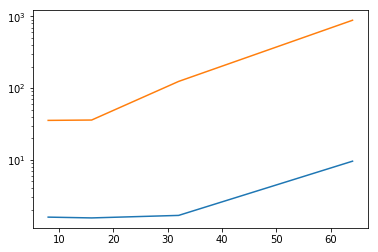

In [69]:
plt.semilogy(t_bl,t_mf)
plt.semilogy(t_bl,t_da)

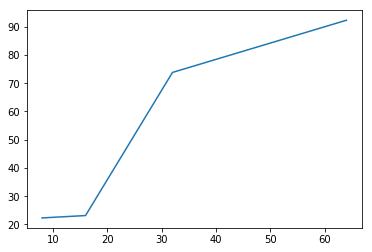

In [73]:
plt.plot(t_bl,[t_da[i]/t_mf[i] for i in range(len(t_mf))])

This looks like it almost worse than a constant offset as the box size get's larger, which is very confusing. Let's resume testing on full 2048 set just to make sure.